In [1]:
%load_ext autoreload
from collections import defaultdict
import logging
import glob

import simpy
import numpy as np
import pandas as pd
import nevergrad as ng
from functools import partial
from matplotlib import pyplot as plt

logging.basicConfig(filename='plc.log', filemode='w',encoding='utf-8', level=logging.WARNING)

INFO:matplotlib.font_manager:generated new fontManager


In [2]:
%autoreload 2

import part_lifecycle as plc
import study_funcs as sf

budgets = [75,150,300,1000]

## Optimizer convergence testing
How well do various parameter space searches/global optimizers fare with this problem? Here, a small subselection of the possible methods provided by Nevergrad are tested.

- RandomSearch: random sampling from given parameterization, acts as a benchmark
- PSO : Particle Swarm Optimization 
- TwoPointsDE: Differential Evolution with Two-points Crossover
- TBPSA: Test-Based Population Size Adaptation, an evolutionary method described [here](https://homepages.fhv.at/hgb/New-Papers/PPSN16_HB16.pdf)
- OnePlusOne: Evolutionary search; in the continuous case, a random search with a variable step size; in the discrete case, random mutations of according to a probability dist are made
- NGOpt: Nevergrad's own adaptative optimization algorithm

These algorithms and more are detailed in [this paper](https://www.lamsade.dauphine.fr/~cazenave/papers/games_cec.pdf), and can find further references therein.

The default parameters for each optimization algorithm are used here; the choice of these parameters can have a significant impact of performance and in practical cases should be tuned (which itself is an optimization, but often done heuristically). In this case, I'm not deep diving into global optimization algorithm parameter tuning so I'll stick with the defaults.

In [3]:
def study_par_helper(budget,name):
    
    act_scrap_params = {'const':0.5}
    pred_scrap_params = {'const':0.5}
    
    q_init = ng.p.Scalar(lower=1, upper=1e3).set_integer_casting()
    prepro_through = ng.p.Scalar(lower=1, upper=200).set_integer_casting()
    rep_through = ng.p.Scalar(lower=1, upper=200).set_integer_casting()
    r = ng.p.Scalar(lower=750, upper=2e4).set_integer_casting()
    q = ng.p.Scalar(lower=150, upper=1e5).set_integer_casting()
    
    parametrization = ng.p.Instrumentation(q_init=q_init,prepro_through=prepro_through,rep_through=rep_through,\
                                               r=r,q=q)
    opt_sampled_points = []
    opt_func = partial(sf.run_sim, 'r_q',act_scrap_params,pred_scrap_params)

    def save_candidate_and_value(optimizer, candidate, value):
        opt_sampled_points.append({'name':name,'candidate':candidate, 'value':value})
        
    optim = ng.optimizers.registry[name](parametrization=parametrization, budget=budget)
    optim.register_callback("tell", save_candidate_and_value)
    rq_recommendation = optim.minimize(opt_func)
    
    return opt_sampled_points

In [ ]:
import multiprocessing as mp

budget_data = {}
for budget in budgets:
    names = ['RandomSearch','PSO','TwoPointsDE','TBPSA','OnePlusOne','NGOpt']

    opt_func = partial(study_par_helper, budget)
    pool = mp.Pool(processes=len(names))
    results = pool.map(opt_func, names)

    opt_sampled_points = [x for y in results for x in y]
    df = pd.DataFrame(data=opt_sampled_points)
    df_res = pd.merge(df[['name','value']],pd.DataFrame(data=df['candidate'].map(lambda x: x[1].value).to_list()), left_index=True, right_index=True)
    df_res.to_parquet(f'../data/optimizer_study_{budget}.parquet')

# Results Analysis
The optimizers' convergence is plotted below. Running the above optimization takes 3+ hours, so I don't recommend re-running it and to simply read the precalculated results.

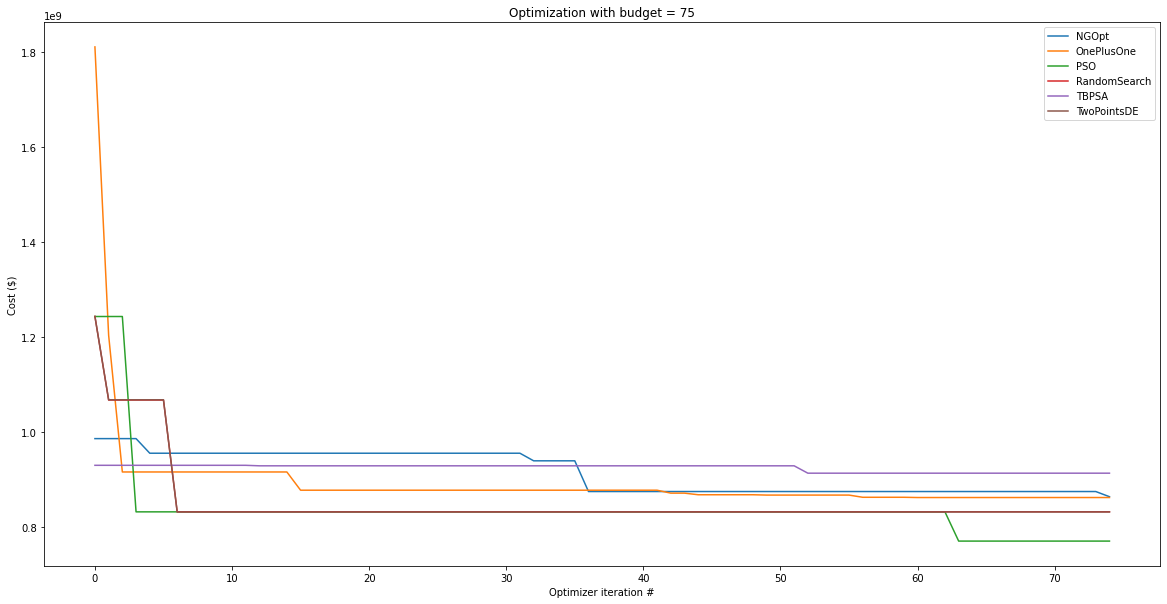

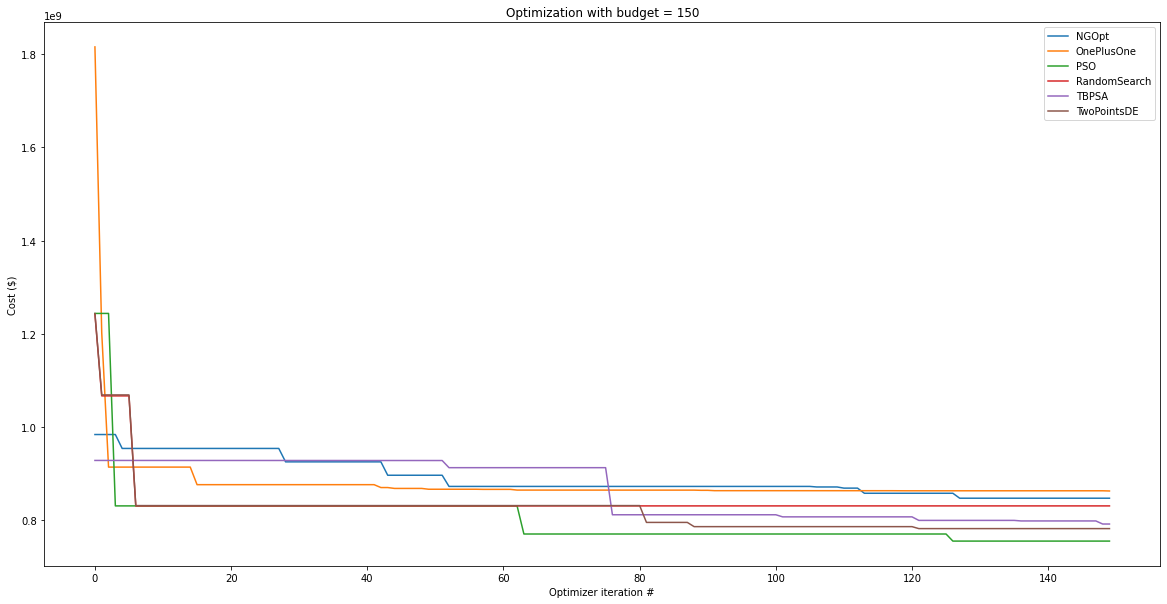

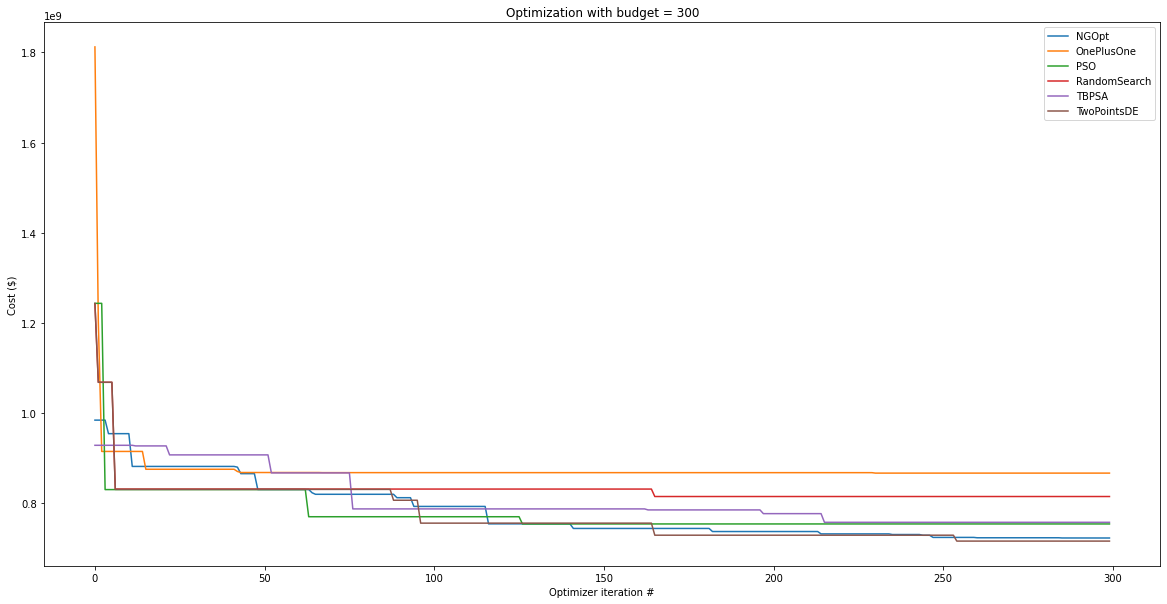

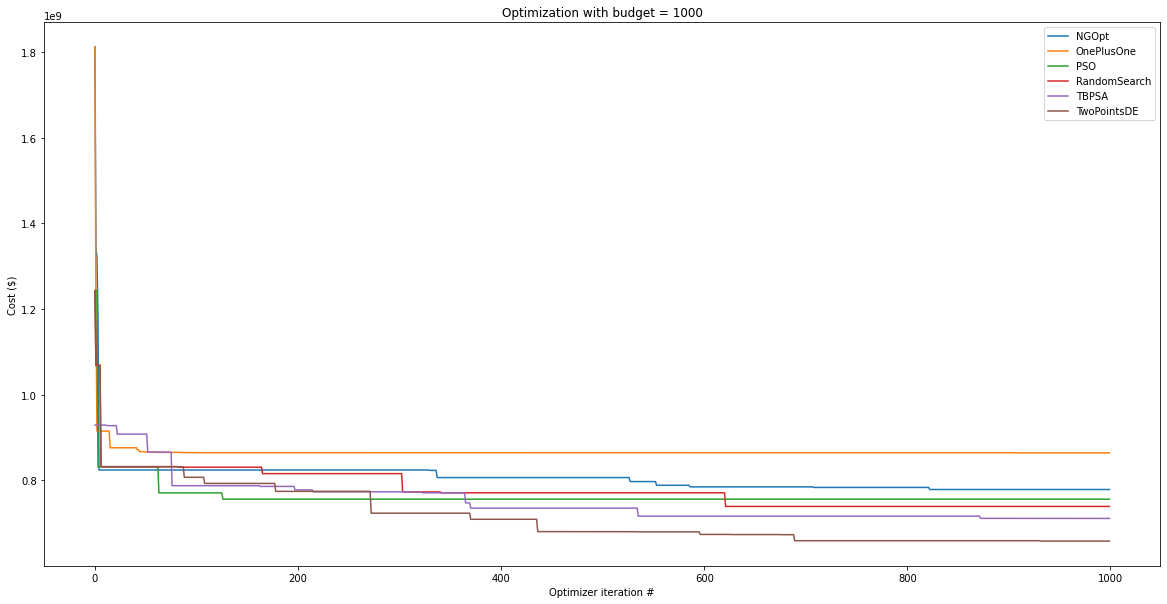

In [3]:
# Read in the results files
res_files = [f'../data/optimizer_study_{budget}.parquet'for budget in budgets]

# Iterate over each budget and plot the expanding minimum to evaluate convergence.
final_values = []
for file in res_files:

    df_res = pd.read_parquet(file)
    budget = file.split('_')[-1].split('.')[0]
    
    
    plt.figure(figsize=(20,10))
    for name, group in df_res.groupby('name'):
        final_values.append({'budget':int(budget),'algo':name,'cost':group['value'].min()})
        plt.plot(group['value'].expanding().min().values, label=name)

    plt.legend()
    plt.title(f'Optimization with budget = {budget}')
    plt.ylabel('Cost ($)')
    plt.xlabel('Optimizer iteration #')
    plt.show()

## Analysis

I've run the optimization over several budgets because some optimizers adapt to the budget to best balance exploration and exploitation. PSO and TwoPointsDE tend to lead the pack in early stages (<~300 iterations). PSO then tends to plateau, while TwoPointsDE continues to find better candidate points with increasing budget.

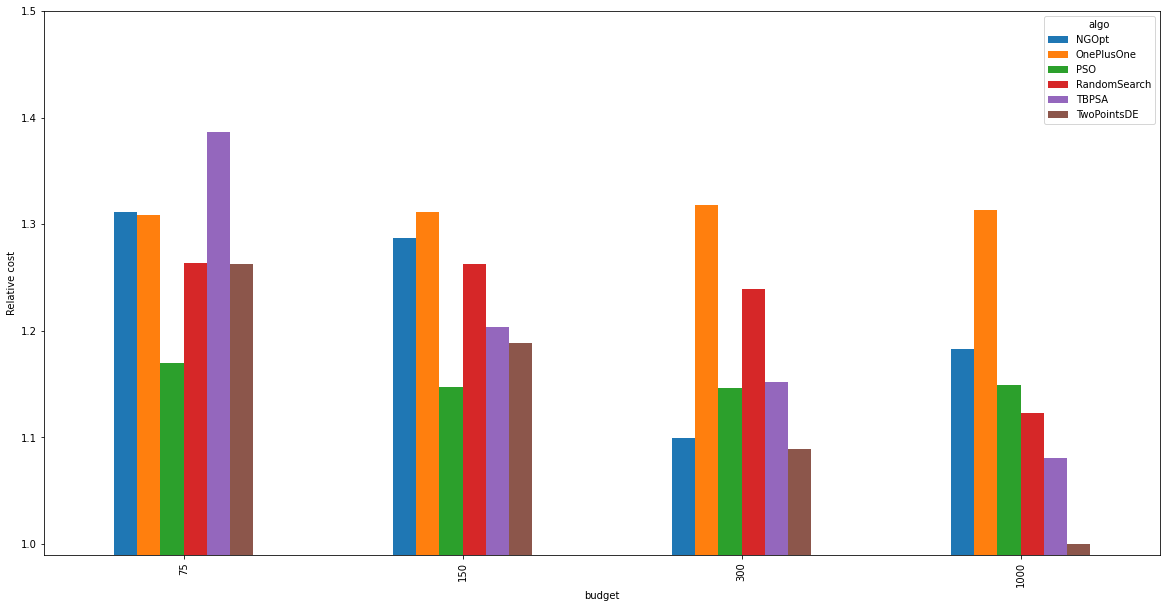

In [6]:
df_final_v = pd.DataFrame(data=final_values)
df_final_v['rel_cost'] = df_final_v['cost']/df_final_v['cost'].min()
df_final_v = df_final_v.pivot(index='budget', columns='algo', values='rel_cost').sort_index()
df_final_v.plot(kind='bar', figsize=(20,10))
plt.ylabel('Relative cost')
plt.ylim(0.99,1.5)
plt.show()

## Analysis
Here, the final cost of each budget and optimization algorithm is plotted relative to the minimum cost (here, TwoPointsDE with a budget of 1000). Several observations can be made for this specific problem:

- PSO leads by a good margin with lower budgets
- TwoPointsDE steadily improves with budget and is the most performant optimizer with a budget of 1000.
- Random search beats OnePlusOne in every case, and is often in the middle of the pack.

These figures represent a single optimization run, which given the stochastic nature of sampling of these algorithms, is not representative. This is clear from the non-monotonic decrease in relative cost, particularly for NGOpt. In a commercial case, each optimization should be repeated a number of times to evaluate the uncertainty of the results, and a larger budget should be tested. 

In other studies/notebooks, TwoPointsDE with a budget of 1000 is used.